# Data prerocessing for cSIM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft,ifft, fft2, ifft2, fftshift, ifftshift


from IPython import display
import pickle
import glob
from PIL import Image


%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use(['dark_background'])


In [2]:
# Arrayfire implementation

import arrayfire as af
from cSIM_func_af import *

af.set_backend('cuda')
af.set_device(2)
af.device_info()

### If no arrayfire / llops, please import the following instead:
# from cSIM_func import *

{'device': 'GeForce_GTX_1080_Ti',
 'backend': 'CUDA',
 'toolkit': 'v8',
 'compute': '6.1'}

In [89]:
# Experimental parameters

lambda_c = 0.532           # fluorescence wavelength
mag = 5                   # system magnification
pscrop = 5.5/mag           # effective pixel size on camera plane
NA_obj = 0.1               # Objective NA
Ns = 300                   # data cropping y size
Ms = 300                   # data cropping x size
upsamp_factor = 4          # upsampling factor (should upsample to Nyquist of expected resolution)
NAs = 0.3
z_camera = np.array([0,-32]) # camera defocus
bg = 96


# cropping starting point of fluorescent/coherent images
nstart_c1 = [34 + 480, 16 + 600] # [cam_pos + crop_pos]
nstart_c2 =  [1 + 480, 74 + 600]  # [cam_pos + crop_pos]


In [9]:
# File sorting helper function

import re
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


In [49]:
# Load raw fluorescent images from the folder

filedir_c1 = '/media/hugespace/Li-Hao/cSIM/data/data_035/data_image2/ptgrey1_*.tif'
files_c1 = sorted(glob.glob(filedir_c1), key=numericalSort)


filedir_c2 = '/media/hugespace/Li-Hao/cSIM/data/data_035/data_image2/ptgrey2_*.tif'
files_c2 = sorted(glob.glob(filedir_c2), key=numericalSort)


Nimg = len(files_c1)
Ic_image = np.zeros((2, Nimg, Ns, Ms))

for i in range(0, Nimg):
    # Load coherent data at z_1
    Ic1 = plt.imread(files_c1[i]).astype('float64')
#     I = np.maximum(0,np.array(Image.fromarray(I).resize((1536,1296),Image.BICUBIC)))
    Ic_image[0,i] = Ic1[nstart_c1[0]:nstart_c1[0]+Ns,nstart_c1[1]:nstart_c1[1]+Ms]
    
    # Load coherent data at z_2
    Ic2 = plt.imread(files_c2[i]).astype('float64')
    Ic2 = np.array(Image.fromarray(np.fliplr(Ic2)).resize((1302,989), Image.BICUBIC))[0:988,0:1300]
    Ic2 = np.abs(rotate(Ic2, -np.pi*0.43/180))
    Ic_image[1,i] = Ic2[nstart_c2[0]:nstart_c2[0]+Ns,nstart_c2[1]:nstart_c2[1]+Ms]

    
    if np.mod(i+1,100) == 0 or i+1 == Nimg:
        print('Data loading process (%d / %d)'%(i+1,Nimg))


Data loading process (100 / 1296)
Data loading process (200 / 1296)
Data loading process (300 / 1296)
Data loading process (400 / 1296)
Data loading process (500 / 1296)
Data loading process (600 / 1296)
Data loading process (700 / 1296)
Data loading process (800 / 1296)
Data loading process (900 / 1296)
Data loading process (1000 / 1296)
Data loading process (1100 / 1296)
Data loading process (1200 / 1296)
Data loading process (1296 / 1296)


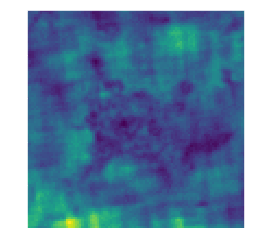

In [50]:
plt.imshow(np.mean(Ic_image[0,:,70:170,10:110],axis=0))

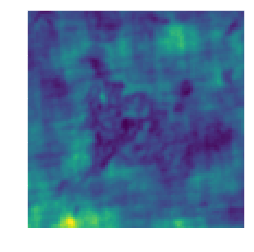

In [51]:
plt.imshow(np.mean(Ic_image[1,:,70:170,10:110],axis=0))

In [60]:
# Camera calibration

mean_intensity = np.mean(Ic_image,(2,3))

N_defocus, Nimg, N_L, M_L = Ic_image.shape

fx_L = np.r_[-M_L/2:M_L/2]/pscrop/M_L
fy_L = np.r_[-N_L/2:N_L/2]/pscrop/N_L

fxx_L, fyy_L = np.meshgrid(fx_L,fy_L)

fxx_L = ifftshift(fxx_L)
fyy_L = ifftshift(fyy_L)

cor_shift = np.zeros((2,Nimg))


for i in range(0,Nimg):
    output = dftregistration(fft2(Ic_image[1,i]),fft2(Ic_image[0,i]),100)
    cor_shift[0,i] = output[0]
    cor_shift[1,i] = output[1]
    

global_shift = np.mean(cor_shift,axis=1)
    

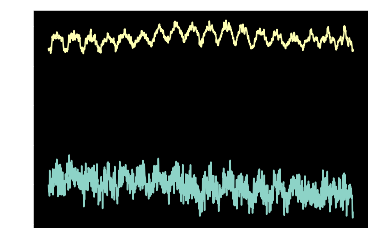

In [77]:
# Monitor mean intensity fluctuation

plt.plot(mean_intensity[0])
plt.plot(mean_intensity[1])

(-2, 2, -2, 2)

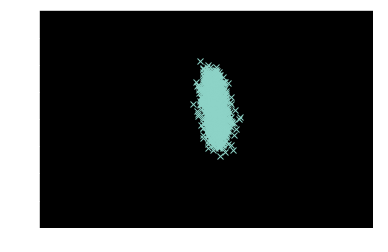

In [88]:
# Monitor registration fluctuation

plt.plot(cor_shift[1,:],cor_shift[0,:],'x')
plt.axis((-2, 2, -2, 2))

In [74]:
# Calibrating the measurement

Ic_image_cali = np.zeros_like(Ic_image)
Ic_image_cali[0] = np.maximum(0,np.real(ifft2(fft2(Ic_image[0], axes=(1,2)) * \
                         np.reshape(np.exp(-1j*2*np.pi*pscrop*(fxx_L * global_shift[1] +\
                                                               fyy_L *global_shift[0])),(1,N_L,M_L)), axes=(1,2))))
Ic_image_cali[1] = Ic_image[1]*np.mean(mean_intensity[0])/np.mean(mean_intensity[1])
Ic_image_cali = Ic_image_cali[:,:,70:170,10:110]

In [90]:
f = open('coherent_data.pckl', 'wb')
pickle.dump((pscrop,lambda_c,NA_obj,z_camera,Ic_image_cali,\
             upsamp_factor,bg), f)
f.close()